# Tutorial: Use Great Expectations to validate  Power BI datasets
This tutorial illustrates how to use Semantic Link together with [Great Expectations](https://greatexpectations.io/) to perform data validation.

### In this tutorial, you learn how to:
- Evaluate Power BI measures programmatically via a Python interface of Semantic Link's Python library ([SemPy](https://learn.microsoft.com/en-us/python/api/semantic-link-sempy)), apply filtering, grouping, and so on.
- Get familiarized with components of SemPy that help bridge the gap between AI and BI. These components include:
    - FabricDataFrame - a pandas-like structure enhanced with additional semantic information.
    - Useful functions that allow you to fetch Power BI datasets, including raw data, configurations, and measures.

### Prerequisites

* A [Microsoft Fabric subscription](https://learn.microsoft.com/fabric/enterprise/licenses). Or sign up for a free [Microsoft Fabric (Preview) trial](https://learn.microsoft.com/fabric/get-started/fabric-trial).
* Sign in to [Microsoft Fabric](https://fabric.microsoft.com/).
* Go to the Data Science experience in Microsoft Fabric.
* Select **Workspaces** from the left navigation pane to find and select your workspace. This workspace becomes your current workspace.
* Download the [_Retail Analysis Sample PBIX.pbix_](https://download.microsoft.com/download/9/6/D/96DDC2FF-2568-491D-AAFA-AFDD6F763AE3/Retail%20Analysis%20Sample%20PBIX.pbix) dataset and upload it to your workspace.
* Open your notebook. You have two options:
    * [Import this notebook into your workspace](https://learn.microsoft.com/en-us/fabric/data-engineering/how-to-use-notebook#import-existing-notebooks). You can import from the Data Science homepage.
    * Alternatively, you can create [a new notebook](https://learn.microsoft.com/fabric/data-engineering/how-to-use-notebook#create-notebooks) to copy/paste code into cells.

## Set up the notebook

In this section, you set up a notebook environment with the necessary modules and data.

1. install `SemPy` from PyPI using the `%pip` in-line installation capability within the notebook.

In [1]:
# install libraries
%pip install semantic-link great-expectations great_expectations_experimental great_expectations_zipcode_expectations

# load %%dax cell magic
%load_ext sempy

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 10, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 83.7 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 123.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 128.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 145.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 124.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.5/284.5 kB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 137.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

2. Perform necessary imports of modules that you'll need later: 

In [2]:
import great_expectations as gx
from great_expectations.expectations.expectation import ExpectationConfiguration
from great_expectations_zipcode_expectations.expectations import expect_column_values_to_be_valid_zip5, expect_column_values_to_be_valid_alabama_zip

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 12, Finished, Available)

/nfs4/pyenv-7053fd41-3592-4d02-afa4-78ae2593d477/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')



## Setup Great Expectation context and data source

Setup Great Expectation context and create data source using Semantic Link.
This establishes the connection to the Retail Analysis Sample PBIX dataset.

In [3]:
context = gx.get_context()

ds = context.sources.add_fabric_powerbi("Retail Analysis Data Source", dataset="Retail Analysis Sample PBIX")

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 13, Finished, Available)

Created temporary directory '/tmp/tmp176f7_50' for ephemeral docs site


## Data assets

Add data assets for tables, measures and DAX query

In [12]:
ds.add_powerbi_table_asset("Store Asset", table="Store")

ds.add_powerbi_measure_asset(
    "Total Units Asset",
    measure="TotalUnits",
    groupby_columns=["Time[FiscalYear]", "Time[FiscalMonth]"]
)

ds.add_powerbi_dax_asset(
    "Total Units YoY Asset",
    dax_string="""
EVALUATE SUMMARIZECOLUMNS(
    'Time'[FiscalYear],
    'Time'[FiscalMonth],
    "Total Units Ratio", DIVIDE([Total Units This Year], [Total Units Last Year])
)    
""")

# https://dax.tips/2019/11/28/clean-data-faster-reports/
ds.add_powerbi_dax_asset(
    "Referential Integrity Violation",
    dax_string="""
SELECT
    [Database_name],
    [Dimension_Name],
    [RIVIOLATION_COUNT]
FROM $SYSTEM.DISCOVER_STORAGE_TABLES
""")

None

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 23, Finished, Available)

Created temporary directory '/tmp/tmpl3_woi23' for ephemeral docs site


## Expectations

Configure expectations to validate the data

In [13]:
# Configure expections for Store table
suite_store = context.add_expectation_suite("Retail Store Suite")

# the alabama one is expected fail
suite_store.add_expectation(ExpectationConfiguration("expect_column_values_to_be_valid_zip5", { "column": "PostalCode" }))
suite_store.add_expectation(ExpectationConfiguration("expect_column_values_to_be_valid_alabama_zip", { "column": "PostalCode" }))
suite_store.add_expectation(ExpectationConfiguration("expect_table_row_count_to_be_between", { "min_value": 80, "max_value": 200 }))

context.add_or_update_expectation_suite(expectation_suite=suite_store)

# Configure expections for measures
suite_measure = context.add_expectation_suite("Retail Measure Suite")
suite_measure.add_expectation(ExpectationConfiguration(
    "expect_column_values_to_be_between", 
    {
        "column": "TotalUnits",
        "min_value": 50000
    }))

context.add_or_update_expectation_suite(expectation_suite=suite_measure)

# Configure expectations for DAX
suite_dax = context.add_expectation_suite("Retail DAX Suite")
suite_dax.add_expectation(ExpectationConfiguration(
    "expect_column_values_to_be_between", 
    {
        "column": "[Total Units Ratio]",
        "min_value": 0.8,
        "max_value": 1.5
    }))

context.add_or_update_expectation_suite(expectation_suite=suite_dax)


# Configure expectations for DAX
suite_dmv = context.add_expectation_suite("Retail DMV Suite")
suite_dmv.add_expectation(ExpectationConfiguration(
    "expect_column_values_to_be_between", 
    {
        "column": "RIVIOLATION_COUNT",
        "min_value": 0,
        "max_value": 0
    }))

context.add_or_update_expectation_suite(expectation_suite=suite_dmv)

None

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 24, Finished, Available)

## Validation

Configure a checkpoint and apply the suites to each asset

In [14]:
checkpoint_config = {
    "name": f"Store Checkpoint",
    "validations": [
        {
            "expectation_suite_name": "Retail Store Suite",
            "batch_request": {
                "datasource_name": "Retail Analysis Data Source",
                "data_asset_name": "Store Asset",
            },
        },
        {
            "expectation_suite_name": "Retail Measure Suite",
            "batch_request": {
                "datasource_name": "Retail Analysis Data Source",
                "data_asset_name": "Total Units Asset",
            },
        },
        {
            "expectation_suite_name": "Retail DAX Suite",
            "batch_request": {
                "datasource_name": "Retail Analysis Data Source",
                "data_asset_name": "Total Units YoY Asset",
            },
        },
        {
            "expectation_suite_name": "Retail DMV Suite",
            "batch_request": {
                "datasource_name": "Retail Analysis Data Source",
                "data_asset_name": "Referential Integrity Violation",
            },
        },
    ],
}
checkpoint = context.add_checkpoint(
    **checkpoint_config,
)
result = checkpoint.run()

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 25, Finished, Available)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/15 [00:00<?, ?it/s]

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 26, Finished, Available)

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 27, Finished, Available)

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 28, Finished, Available)

Extract the results for simple formatting

In [15]:
import pandas as pd

data = []

for run_result in result.run_results:
    for validation_result in result.run_results[run_result]["validation_result"]["results"]:
        row = {
            "Batch ID": run_result.batch_identifier,
            "type": validation_result.expectation_config.expectation_type,
            "success": validation_result.success
        }

        row.update(dict(validation_result.result))
        
        data.append(row)

df = pd.DataFrame.from_records(data)    

df[["Batch ID", "type", "success", "element_count", "unexpected_count", "partial_unexpected_list"]]

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 29, Finished, Available)

,Batch ID,type,success,element_count,unexpected_count,partial_unexpected_list
0,Retail Analysis Data Source-Store Asset,expect_column_values_to_be_valid_zip5,True,104.0,0.0,[]
1,Retail Analysis Data Source-Store Asset,expect_column_values_to_be_valid_alabama_zip,False,104.0,104.0,"[26032, 25801, 26554, 15401, 26101, 15012, 215..."
2,Retail Analysis Data Source-Store Asset,expect_table_row_count_to_be_between,True,NaN,NaN,NaN
3,Retail Analysis Data Source-Total Units Asset,expect_column_values_to_be_between,True,8.0,0.0,[]
4,Retail Analysis Data Source-Total Units YoY Asset,expect_column_values_to_be_between,False,8.0,3.0,"[0.7972605895837893, 0.7302630613281353, 0.663..."
5,Retail Analysis Data Source-Referential Integr...,expect_column_values_to_be_between,True,84.0,0.0,[]


## Diagnostics

Fetch source data to understand which years are outside of the range

In [16]:
%%dax "Retail Analysis Sample PBIX"

EVALUATE SUMMARIZECOLUMNS(
    'Time'[FiscalYear],
    'Time'[FiscalMonth],
    "Total Units Ratio", DIVIDE([Total Units This Year], [Total Units Last Year])
)

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 30, Finished, Available)

,Time[FiscalYear],Time[FiscalMonth],[Total Units Ratio]
0,2014,Jan,0.797261
1,2014,Feb,0.95912
2,2014,Mar,1.282908
3,2014,Apr,0.730263
4,2014,May,1.084064
5,2014,Jun,0.969717
6,2014,Jul,0.663352
7,2014,Aug,0.810861


In [17]:
df = _

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 31, Finished, Available)

StatementMeta(, efb436d1-09b2-43ab-a318-5b84c484989f, 33, Finished, Available)

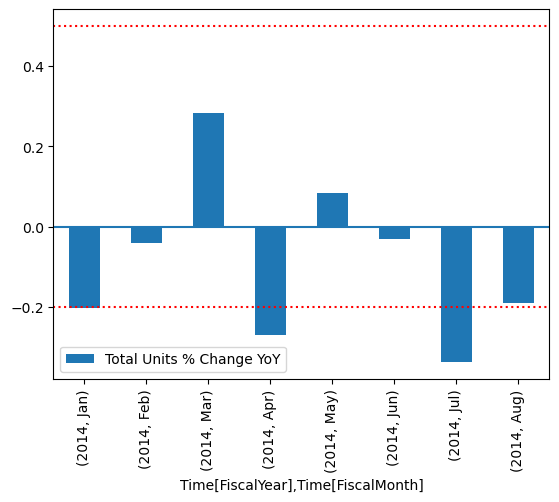

In [19]:
import matplotlib.pyplot as plt

df["Total Units % Change YoY"] = (df["[Total Units Ratio]"] - 1)

df.set_index(["Time[FiscalYear]", "Time[FiscalMonth]"]).plot.bar(y="Total Units % Change YoY")

plt.axhline(0)

plt.axhline(-0.2, color="red", linestyle="dotted")
plt.axhline( 0.5, color="red", linestyle="dotted")

None